In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf


In [3]:
batch_size = 50
img_height = 224
img_width = 224

In [4]:
ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/UShape"
no_ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/NoUshape"

In [5]:
def extract_spectrograms(path):
  os.chdir(path)
  spectrograms = []

  with os.scandir(path) as files:
    for file in files:
      if file.name.endswith('.png'):
        spectrograms.append(file.path)
  return spectrograms

ushapes_spectrograms = extract_spectrograms(ushapes)
all_spectrograms = extract_spectrograms(no_ushapes)



print(len(ushapes_spectrograms), len(all_spectrograms))
no_ushape_spectrograms = [spectrogram_without_ushape for spectrogram_without_ushape in all_spectrograms if spectrogram_without_ushape not in ushapes_spectrograms]

168 3822


In [29]:
def fill_df_with_label(spectrograms, label):
  new_df =  pd.DataFrame()
  new_df['filename'] = spectrograms
  new_df['label'] = [label] * len(spectrograms)

  return new_df


dataframe_ushape = fill_df_with_label(ushapes_spectrograms, "ushape")
dataframe_noshape = fill_df_with_label(no_ushape_spectrograms, "noshape")

df_train_ushape, df_rest_ushape = train_test_split(dataframe_ushape, random_state = 101, train_size=110)
df_train_no_shape, df_rest_no_shape = train_test_split(dataframe_noshape, random_state = 101, train_size=110)

df_val_ushape, df_test_ushape = train_test_split(df_rest_ushape, random_state = 101, train_size=55)
df_val_no_ushape, df_test_no_shape = train_test_split(df_rest_no_shape, random_state = 101, train_size=55)

df_train = df_train_ushape.append(df_train_no_shape)
df_train = df_train.sample(frac=1)

df_val = df_val_ushape.append(df_val_no_ushape)
df_val = df_val.sample(frac=1)


In [30]:
print(len(df_train.loc[df_train["label"] == "ushape"]))
print(len(df_val.loc[df_val["label"] == "ushape"]))

110
55


In [31]:
import scipy 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    # directory='harp/training/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

val_generator = train_datagen.flow_from_dataframe(
    df_val,
    # directory='harp/validation/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

Found 220 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.


In [32]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [33]:
#num_classes = len(class_names)
model = Sequential([
  #data_augmentation,
  layers.Input(shape=(224, 224, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [34]:
epochs = 50
history = model.fit_generator(generator=
  train_generator,
  validation_data=val_generator,
  epochs=epochs
)

c:\y\HARP_3_7\venv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """
c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1864: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1874: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/50
7/7 [==============================] - 42s 5s/step - loss: 0.8249 - tp: 49.0000 - fp: 43.0000 - tn: 67.0000 - fn: 61.0000 - accuracy: 0.5273 - precision: 0.5326 - recall: 0.4455 - auc: 0.5495 - prc: 0.5188 - val_loss: 0.6599 - val_tp: 7.0000 - val_fp: 0.0000e+00 - val_tn: 55.0000 - val_fn: 48.0000 - val_accuracy: 0.5636 - val_precision: 1.0000 - val_recall: 0.1273 - val_auc: 0.7499 - val_prc: 0.7790
Epoch 2/50
7/7 [==============================] - 30s 4s/step - loss: 0.6772 - tp: 65.0000 - fp: 42.0000 - tn: 68.0000 - fn: 45.0000 - accuracy: 0.6045 - precision: 0.6075 - recall: 0.5909 - auc: 0.6423 - prc: 0.6407 - val_loss: 0.6732 - val_tp: 44.0000 - val_fp: 30.0000 - val_tn: 25.0000 - val_fn: 11.0000 - val_accuracy: 0.6273 - val_precision: 0.5946 - val_recall: 0.8000 - val_auc: 0.7185 - val_prc: 0.7122
Epoch 3/50
7/7 [==============================] - 30s 5s/step - loss: 0.6660 - tp: 97.0000 - fp: 76.0000 - tn: 34.0000 - fn: 13.0000 - accuracy: 0.5955 - precision: 0.5607 - 

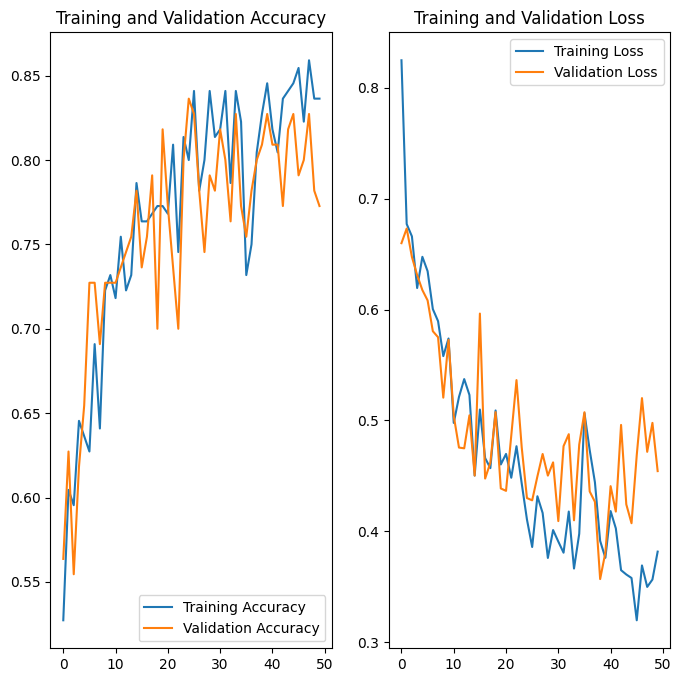

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [36]:
model.save('./cnn_50_epoch_more_metrics_balanced_dataset')

INFO:tensorflow:Assets written to: ./cnn_50_epoch_more_metrics_balanced_dataset\assets


INFO:tensorflow:Assets written to: ./cnn_50_epoch_more_metrics_balanced_dataset\assets


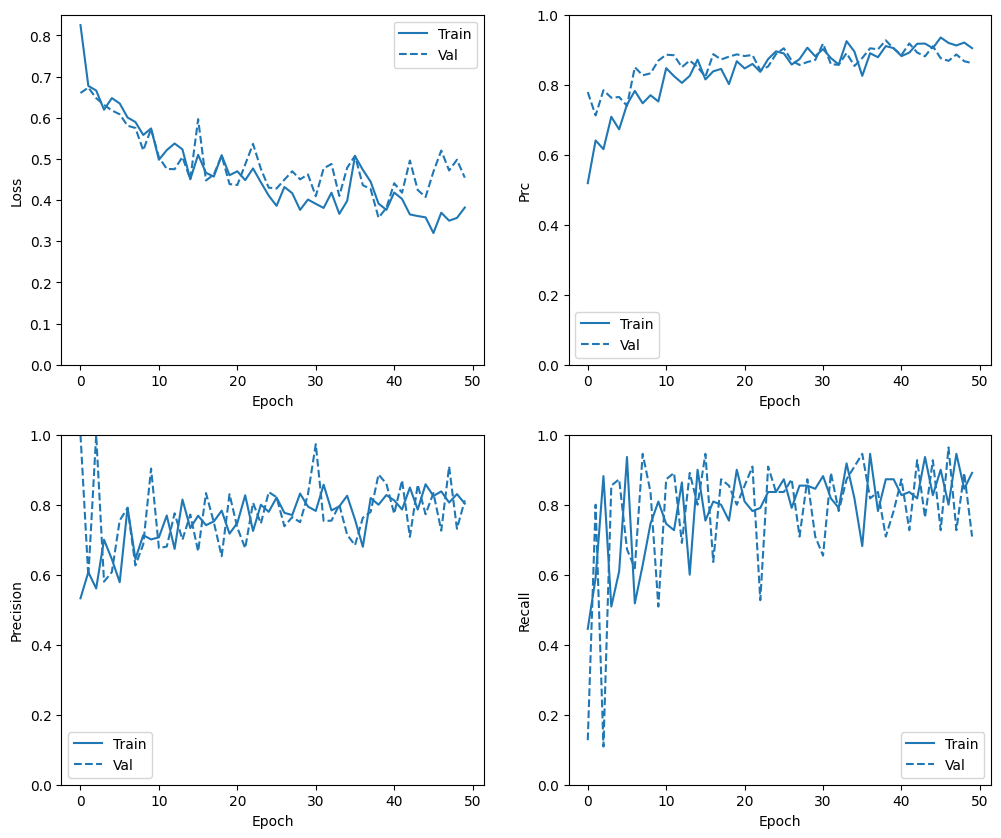

In [37]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)


In [38]:
df_eval = df_test_ushape.append(df_test_no_shape)
df_eval = df_eval.sample(frac=1)

In [39]:
from sklearn import metrics
y_predicted_values = []

accuracies = []

for filename in df_eval["filename"]:
    img = tf.keras.utils.load_img(
    filename, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)

    accuracies.append(predictions)

    if predictions > 0.5:
        y_predicted_values.append("ushape")
    else:
        y_predicted_values.append("noshape")

df_eval["predicted"] = y_predicted_values
df_eval["accuracy"] = accuracies


1/1 [==============================] - 0s 36ms/step


In [40]:
y_true = [int(value is 'ushape') for value in df_eval['label']]
y_predict = [int(value is not 'noshape') for value in df_eval['predicted']]


print(metrics.classification_report(y_true=y_true, y_pred=y_predict))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      3657
           1       0.00      0.67      0.01         3

    accuracy                           0.88      3660
   macro avg       0.50      0.77      0.47      3660
weighted avg       1.00      0.88      0.93      3660



442


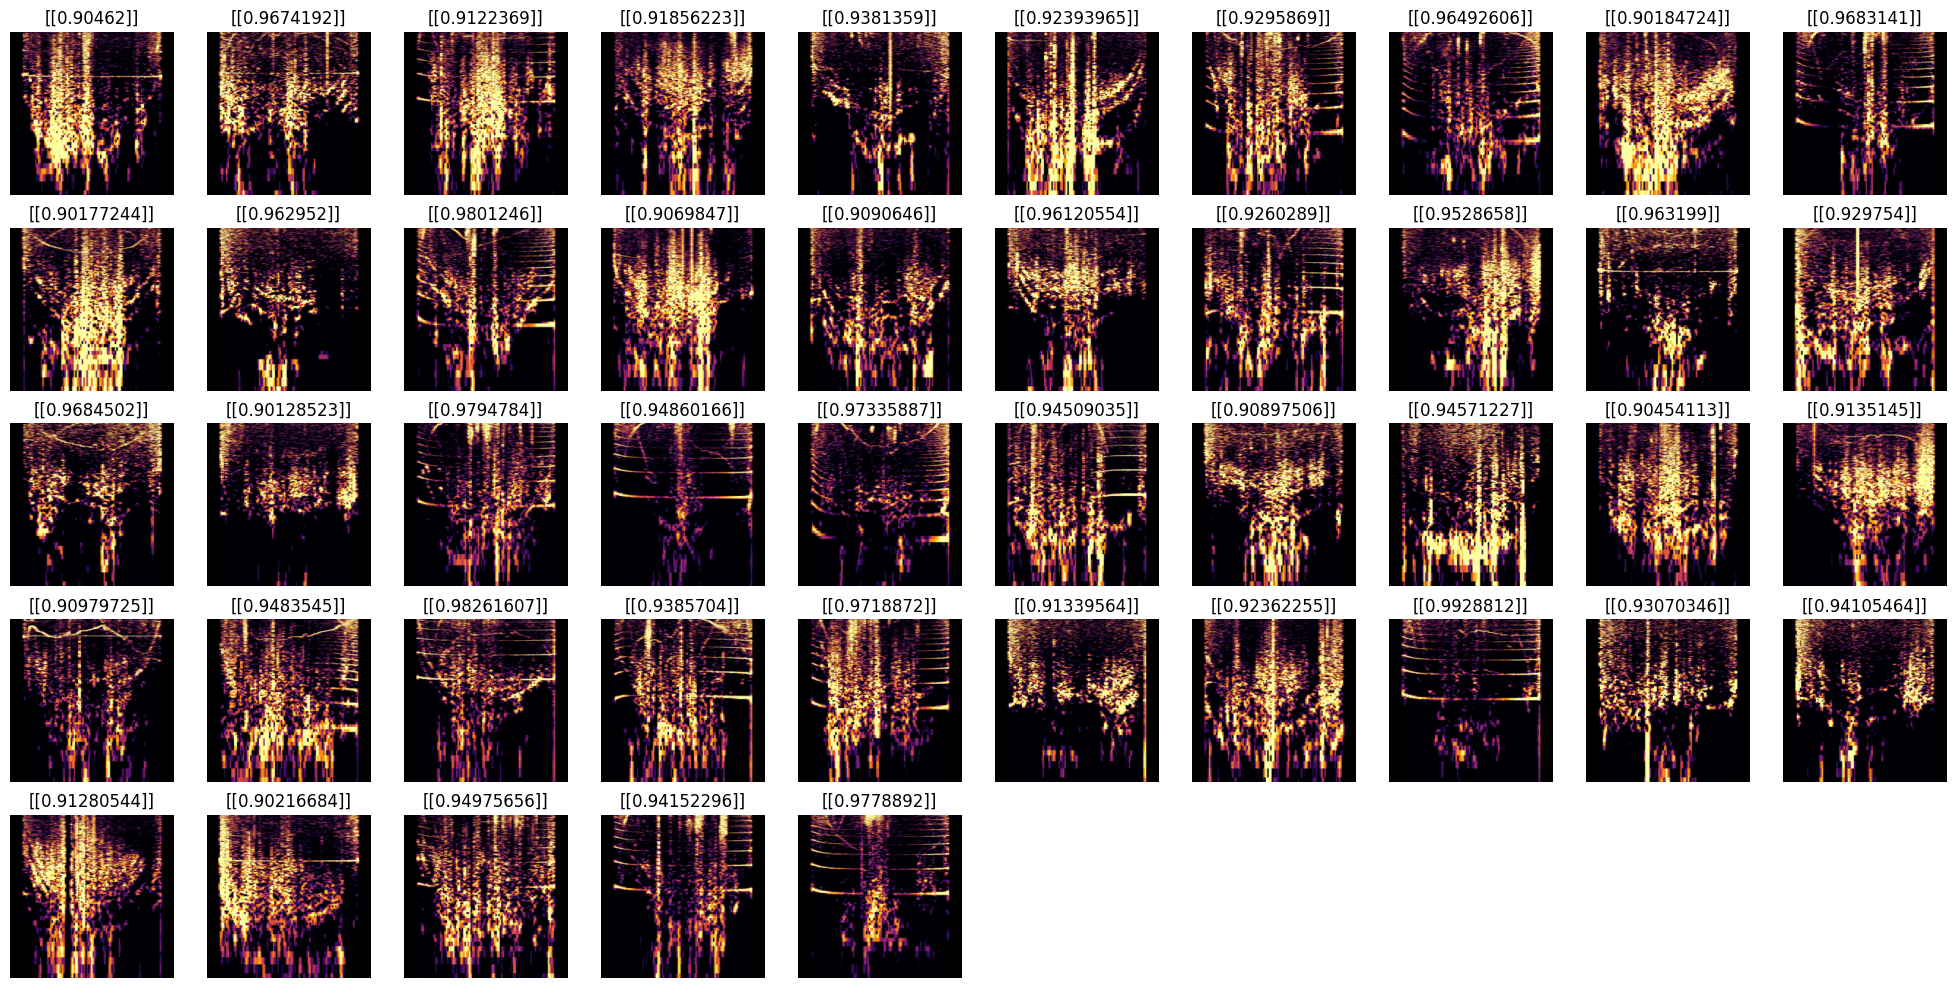

In [48]:
false_true = df_eval.loc[(df_eval['predicted'] == 'ushape') & (df_eval['label'] == "noshape")] 

print(len(false_true))
plt.figure(figsize=(25, 25))

index = 1
for image, accuracy in zip(false_true['filename'],false_true['accuracy']):
    if accuracy > 0.90:
        img = tf.keras.utils.load_img(
            image, target_size=(224, 224)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        ax = plt.subplot(10,10, index)
        ax.set_title(str(accuracy))
        plt.imshow(img)
        plt.axis('off')
        plt.imshow(img_array[0].numpy().astype("uint8"))
        index += 1


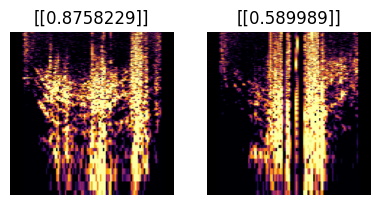

In [47]:
false_true = df_eval.loc[(df_eval['predicted'] == 'ushape') & (df_eval['label'] == "ushape")] 
plt.figure(figsize=(25, 25))

index = 1
for image, accuracy in zip(false_true['filename'],false_true['accuracy']):
    img = tf.keras.utils.load_img(
        image, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    ax = plt.subplot(10,10, index)
    ax.set_title(str(accuracy))
    plt.imshow(img)
    plt.axis('off')
    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1